# Exercise 2 - Tripadvisor Hotel Reviews  dataset

Here is the outline of the exercise:
* load the dataset;
* create features out of text with Tf-idf vectorizer method BoW (unigrams);
* train a model;
* evaluate the model;
* tune the n-grams parameter and repeat the training and evaluation steps (bigrams);
* try 3-grams and different min - max_df and observe the size of features, the vocabulary, the stopwords and importance of the features.

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
%matplotlib inline

### Load dataset

In [2]:
# Add the space character ' ' into the existing list of characters that are intrepreted as missing values
# Because there may be no text in the Review column
missing_values_string = [' ', '', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND',
                         '1.#QNAN', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null']

In [3]:
data = pd.DataFrame(pd.read_csv('../data/tripadvisor_hotel_reviews.csv', na_values=missing_values_string))
data.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [4]:
data['Label'] = [1 if i>=4 else 0 for i in data.Rating.values]

In [5]:
data.head()

,Review,Rating,Label
0,nice hotel expensive parking got good deal sta...,4,1
1,ok nothing special charge diamond member hilto...,2,0
2,nice rooms not 4* experience hotel monaco seat...,3,0
3,"unique, great stay, wonderful time hotel monac...",5,1
4,"great stay great stay, went seahawk game aweso...",5,1


### Remove special characters from reviews and convert to lower case

In [6]:
data.Review = data.Review.apply(lambda x: x.lower()) #lower cases
data.Review = data.Review.apply((lambda x: re.sub('[^a-zA-Z0-9\s]','',x))) 

### Add a column for the length of the reviews

In [7]:
data['Length'] = data.Review.apply(lambda x: len(x.split(' ')))
data.head()

,Review,Rating,Label,Length
0,nice hotel expensive parking got good deal sta...,4,1,89
1,ok nothing special charge diamond member hilto...,2,0,252
2,nice rooms not 4 experience hotel monaco seatt...,3,0,219
3,unique great stay wonderful time hotel monaco ...,5,1,91
4,great stay great stay went seahawk game awesom...,5,1,193


# Training

In [8]:
#Set the features and the target
text = data.Review
label = data.Label

In [9]:
#Split into train and test set
text_train, text_test, y_train, y_test = train_test_split(text, label, test_size=0.25, random_state=0, shuffle=True, stratify=label)

### Create features from the text data

Use TfidfVectorizer instead of CountVectorizer. Are the results better? How are the coefficients different?

Common words like "the", "a", "to" are almost always the terms with highest frequency in the text. Thus, having a high raw count does not necessarily mean that the corresponding word is more important.

To address this problem, one of the most popular ways to "normalize" the term frequencies is to weight a term by the inverse of document frequency, or tf–idf.

In [10]:
#Convert a collection of text documents to a matrix of token counts
#norm = 'l2': Sum of squares of vector elements is 1. OR norm = 'l1': Sum of absolute values of vector elements is 1.
#Note that it is the rows that are normalized, not the columns!
vectorizer = TfidfVectorizer(norm='l1') 
# If a word appears in all the documents, inverse document frequency (idf) will be low and tf-idf will be penalyzed

In TfidfVectorizer we consider overall document weightage of a word. It helps us in dealing with most frequent words. Using it we can penalize them. TfidfVectorizer weights the word counts by a measure of how often they appear in the documents.

But why should we use L1 or L2 norms ?

From sklearn, we understand that:

"Both classes [TfidfTransformer and TfidfVectorizer] also apply L2 normalization after computing the tf-idf representation; in other words, they rescale the representation of each document to have Euclidean norm 1. Rescaling in this way means that the length of a document (the number of words) does not change the vectorized representation."

So Normalizing lets us consider the frequency of words relative to each other, while removing the effect of total word count.

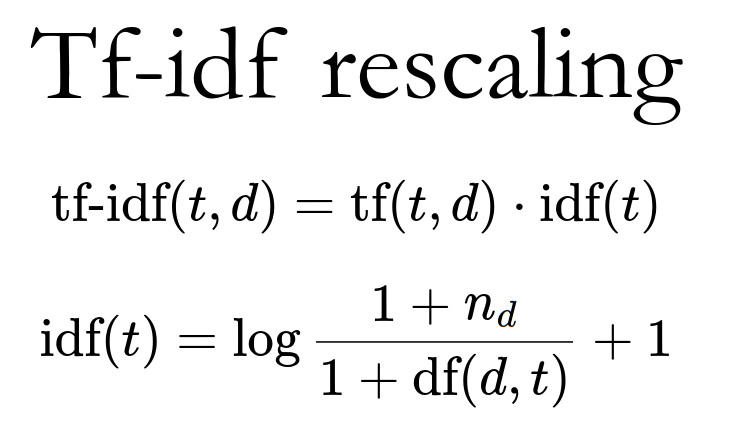

### Keep in mind :
* TF(t, d) will give importance to high frequency words
* IDF(t, d) will penalyze words that occur in all documents
* L1 & L2 normalization give the **same** importance to all documents

tf(t,d) : term frequency => number of times that term t appears in a document t
- High frequency words have higher values of *tf* => high-pass filter

idf(t) : measure of importance of the term *t* in the corpus

- df(d, t): Number of documents the term *t* appears in
- **result** ==> More importance to low-frequency terms (low pass filter)

##### Let's see a simple example first

In [11]:
corpus = ['This is the first document.', 
          'This document is the second document.',
          'And this is the third one.',
          'Is this the first document?' ]

In [12]:
#Retrieve the terms found in the corpus
vectorized_corpus = vectorizer.fit_transform(corpus)
tokens = vectorizer.get_feature_names()
df_vect = pd.DataFrame(data = vectorized_corpus.toarray(), index = ['Doc1','Doc1','Doc3','Doc4'], columns = tokens)
df_vect

,and,document,first,is,one,second,the,third,this
Doc1,0.000000,0.213315,0.263487,0.174399,0.000000,0.000000,0.174399,0.000000,0.174399
Doc1,0.000000,0.332260,0.000000,0.135822,0.000000,0.260274,0.135822,0.000000,0.135822
Doc3,0.219033,0.000000,0.000000,0.114300,0.219033,0.000000,0.114300,0.219033,0.114300
Doc4,0.000000,0.213315,0.263487,0.174399,0.000000,0.000000,0.174399,0.000000,0.174399


In [14]:
vectorized_corpus.toarray()

array([[0.        , 0.21331533, 0.26348688, 0.17439926, 0.        ,
        0.        , 0.17439926, 0.        , 0.17439926],
       [0.        , 0.33225959, 0.        , 0.13582199, 0.        ,
        0.26027443, 0.13582199, 0.        , 0.13582199],
       [0.21903289, 0.        , 0.        , 0.11430045, 0.21903289,
        0.        , 0.11430045, 0.21903289, 0.11430045],
       [0.        , 0.21331533, 0.26348688, 0.17439926, 0.        ,
        0.        , 0.17439926, 0.        , 0.17439926]])

# Now let's vectorize our data

In [48]:
# Extract single words as features (range of n-gram goes from 1 to 1)
# The minimum number of document occurrence of words in 200
# The maximum number of features is 20000
vectorizer2 = TfidfVectorizer(lowercase=True, ngram_range=(1,1), max_df=0.75, min_df=200, max_features=20000, stop_words='english')

In [49]:
len(data[data.Label==0])

5398

In [50]:
len(data[data.Label==1])

15093

In [51]:
len(data)*0.75

15368.25

In [52]:
text_train_vect2 = vectorizer2.fit_transform(text_train)
text_test_vect2 = vectorizer2.transform(text_test)
tokens2 = vectorizer2.get_feature_names()
df_vect2 = pd.DataFrame(data = text_train_vect2.toarray(),columns = tokens2)
display(df_vect2)

,10,100,11,12,14,15,1st,20,2006,2007,...,worst,worth,wow,write,wrong,year,years,yes,york,young
0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
1,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.194440,...,0.0,0.0,0.0,0.0,0.000000,0.271969,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15363,0.000000,0.0,0.0,0.071843,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.070048,0.0,0.000000
15364,0.071363,0.0,0.0,0.000000,0.0,0.084529,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.099957
15365,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.245428,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
15366,0.000000,0.0,0.0,0.000000,0.0,0.146551,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.173300


In [53]:
#Define the training model
RF2 = RandomForestClassifier(n_estimators=100, random_state=0) #try different values for max_depth

#Fit the model on training data
RF_model = RF2.fit(text_train_vect2, y_train)

In [54]:
#Make the model's predictions for the test data
y_test_pred2 = RF2.predict(text_test_vect2)

In [55]:
feature_importance_list2 = sorted(zip(RF2.feature_importances_, tokens2), reverse=True)

In [56]:
feature_imp2 = pd.Series(RF2.feature_importances_, index = tokens2).sort_values(ascending=False)

top_feature2 = feature_imp2.take([0,1,2,3,4,5,6,7,8,9,10])
worst_features2 = feature_imp2.take([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1])

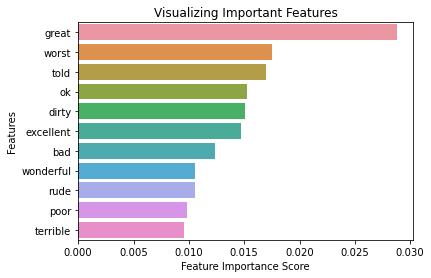

In [57]:
sns.barplot(x=top_feature2, y=top_feature2.index )

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

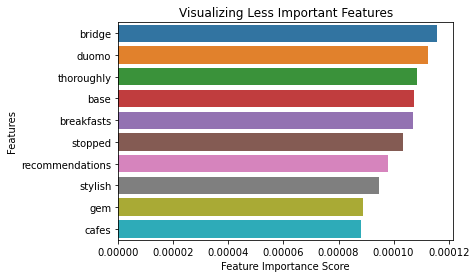

In [58]:
sns.barplot(x=worst_features2, y=worst_features2.index )

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Less Important Features")
plt.show()

In [59]:
print(classification_report(y_test, y_test_pred2))

              precision    recall  f1-score   support

           0       0.89      0.54      0.67      1350
           1       0.86      0.98      0.91      3773

    accuracy                           0.86      5123
   macro avg       0.87      0.76      0.79      5123
weighted avg       0.87      0.86      0.85      5123



<function matplotlib.pyplot.show(*args, **kw)>

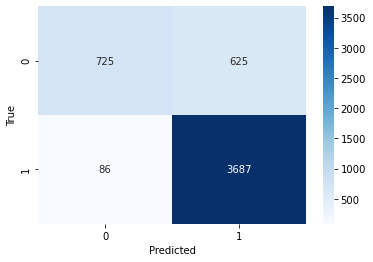

In [60]:
#create the confusion matrix
cf_matrix = confusion_matrix(y_test, y_test_pred2)

#plot the confusion matrix
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show

In [61]:
#vectorizer2.vocabulary_

### What is ngram_range parameter doing ? 

The Bag-of-words model is an orderless document representation which means that only the counts of words matter.

The n-gram model can store spatial information. It creates features of n words which are located the one next to each other in a text. 

For example : "I love it, don't miss it" is different from "I don't love it" both docs contain the words "love" and
    "don't" but in different position in the sentence which makes "love" very different to "don't love".
    
2-grams would create features like that among others :  doc1 => "love it", "don't miss"  doc2=> "don't love", "love it" so **n-grams can capture local contexts**

In [62]:
vectorizer3 = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,2), max_df=0.75, min_df=200, max_features=20000)

In [63]:
text_train_vect3 = vectorizer3.fit_transform(text_train)
text_test_vect3 = vectorizer3.transform(text_test)
tokens3 = vectorizer3.get_feature_names()
df_vect3 = pd.DataFrame(data = text_train_vect3.toarray(),columns = tokens3)
df_vect3

,10,10 minute,10 minutes,100,11,12,14,15,15 minutes,1st,...,worth,wow,write,wrong,year,year old,years,yes,york,young
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.237549,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15363,0.000000,0.0,0.000000,0.0,0.0,0.070402,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.068643,0.0,0.000000
15364,0.069355,0.0,0.102277,0.0,0.0,0.000000,0.0,0.082151,0.105843,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.097145
15365,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
15366,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.139191,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.164596


In [79]:
#vectorizer3.vocabulary_

In [80]:
#Define the training model
RF3 = RandomForestClassifier(n_estimators=100, random_state=0) #try different values for max_depth

#Fit the model on training data
RF_model = RF3.fit(text_train_vect3, y_train)

In [81]:
#Make the model's predictions for the test data
y_test_pred3 = RF3.predict(text_test_vect3)

In [82]:
feature_importance_list3 = sorted(zip(RF3.feature_importances_, tokens3), reverse=True)
#feature_importance_list3

In [83]:
feature_imp3 = pd.Series(RF3.feature_importances_, index = tokens3).sort_values(ascending=False)

top_feature3 = feature_imp3.take([0,1,2,3,4,5,6,7,8,9,10])
worst_features3 = feature_imp3.take([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1])

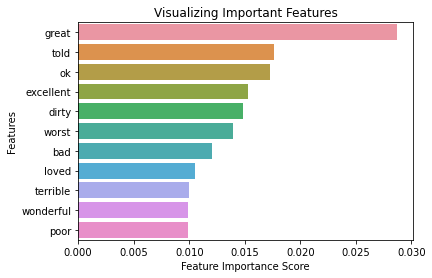

In [84]:
sns.barplot(x=top_feature3, y=top_feature3.index )

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

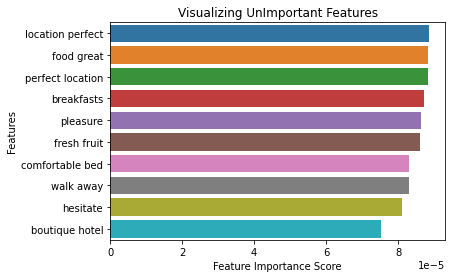

In [85]:
sns.barplot(x=worst_features3, y=worst_features3.index )

# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing UnImportant Features")
plt.show()

In [86]:
print(classification_report(y_test, y_test_pred3))

              precision    recall  f1-score   support

           0       0.88      0.55      0.68      1350
           1       0.86      0.97      0.91      3773

    accuracy                           0.86      5123
   macro avg       0.87      0.76      0.80      5123
weighted avg       0.87      0.86      0.85      5123



<function matplotlib.pyplot.show(*args, **kw)>

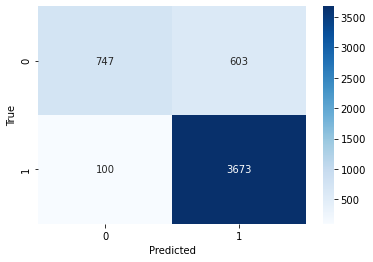

In [87]:
#create the confusion matrix
cf_matrix = confusion_matrix(y_test, y_test_pred3)

#plot the confusion matrix
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show

### Compare the results of unigrams and bigrams

<function matplotlib.pyplot.show(*args, **kw)>

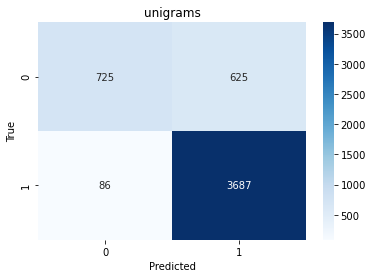

In [88]:
#create the confusion matrix
cf_matrix = confusion_matrix(y_test, y_test_pred2)

#plot the confusion matrix
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('unigrams')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show

In [89]:
print(classification_report(y_test, y_test_pred2))

              precision    recall  f1-score   support

           0       0.89      0.54      0.67      1350
           1       0.86      0.98      0.91      3773

    accuracy                           0.86      5123
   macro avg       0.87      0.76      0.79      5123
weighted avg       0.87      0.86      0.85      5123



<function matplotlib.pyplot.show(*args, **kw)>

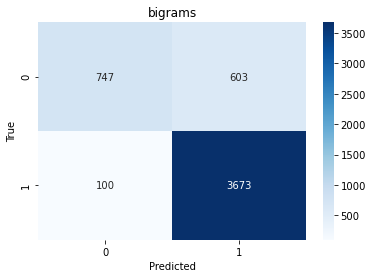

In [90]:
#create the confusion matrix
cf_matrix = confusion_matrix(y_test, y_test_pred3)

#plot the confusion matrix
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('bigrams')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show

In [91]:
print(classification_report(y_test, y_test_pred3))

              precision    recall  f1-score   support

           0       0.88      0.55      0.68      1350
           1       0.86      0.97      0.91      3773

    accuracy                           0.86      5123
   macro avg       0.87      0.76      0.80      5123
weighted avg       0.87      0.86      0.85      5123



The minority class score is better **but the majority class is worse**. As n in n-gram increases, more specific features are created which are less probable to appear in the data. 
This means that the feature matrix becomes more sparse. More sparse data means more difficult to model them, there are less instances that contain this feature.
So, it is a trade-off between capturing context (more information) and getting a large number of features => sparce matrix & not good generalisation on new data & time-cost ==>overfitting.
Unigrams may lead to underfitting. The longer the n-grams the more data we need in order not to underfit. 

### Create a new TfidfVectorizer tuning the n-grams & repeat the training and evaluation process

In [104]:
#Play with max_df, min_df, max_features
vectorizer4 = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1), max_df=0.8, min_df=100, max_features=20)

text_train_vect4 = vectorizer3.fit_transform(text_train)
text_test_vect4 = vectorizer3.transform(text_test)
tokens4 = vectorizer3.get_feature_names()

In [105]:
#Define the training model
RF3 = RandomForestClassifier(n_estimators=100, random_state=0) #try different values for max_depth

#Fit the model on training data
RF_model = RF3.fit(text_train_vect3, y_train)

In [106]:
y_test_pred4 = RF3.predict(text_test_vect4)

print(classification_report(y_test, y_test_pred4))

              precision    recall  f1-score   support

           0       0.88      0.55      0.68      1350
           1       0.86      0.97      0.91      3773

    accuracy                           0.86      5123
   macro avg       0.87      0.76      0.80      5123
weighted avg       0.87      0.86      0.85      5123



In [107]:
df_vect4 = pd.DataFrame(data = text_train_vect4.toarray(),columns = tokens4)
df_vect4

,10,10 minute,10 minutes,100,11,12,14,15,15 minutes,1st,...,worth,wow,write,wrong,year,year old,years,yes,york,young
0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.237549,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15363,0.000000,0.0,0.000000,0.0,0.0,0.070402,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.068643,0.0,0.000000
15364,0.069355,0.0,0.102277,0.0,0.0,0.000000,0.0,0.082151,0.105843,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.097145
15365,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000
15366,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.139191,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.164596


This co-occurrence matrix shows the correlation between words. This can give us hints about the links of words inside the documents

In [109]:
sum_ = df_vect4.sum()

In [112]:
co_occurrence_matrix = df_vect4.T.dot(df_vect4)/sum_

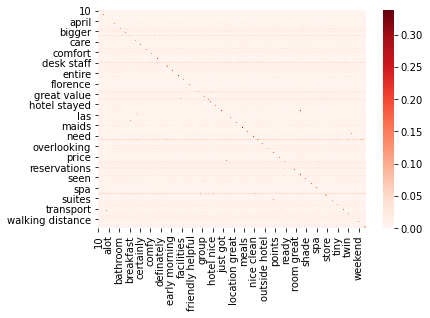

In [116]:
sns.heatmap(data=co_occurrence_matrix, cmap='Reds')

#### To save the best model

In [49]:
#import joblib

In [51]:
# save the model to disk
#filename = 'best_model.sav'
#joblib.dump(RF3, filename)

['best_model.sav']

In [52]:
# load the model from disk
#loaded_model = joblib.load(filename)
#result = loaded_model.score(text_test_vect3, y_test)
#print(result)